In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Concatenate, Dense, Dropout, Embedding, Input, Reshape
import matplotlib.pyplot as plt

#Read data
df=pd.read_parquet('/content/drive/MyDrive/bicing_full.parquet')
variables=['station_id','month','day','hour','weekend','weekday','is_holiday','season','percentage_docks_available','ctx_1','ctx_2','ctx_3','ctx_4','post_code','lon','lat','altitude','capacity','avg_temp', 'max_temp', 'min_temp', 'avg_rel_humidity','acum_precipitation']
df=df[variables]
df=df[::20]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714643 entries, 0 to 14292840
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   station_id                  714643 non-null  uint16  
 1   month                       714643 non-null  uint8   
 2   day                         714643 non-null  uint8   
 3   hour                        714643 non-null  uint8   
 4   weekend                     714643 non-null  bool    
 5   weekday                     714643 non-null  uint8   
 6   is_holiday                  714643 non-null  bool    
 7   season                      714643 non-null  category
 8   percentage_docks_available  714643 non-null  float32 
 9   ctx_1                       714643 non-null  float32 
 10  ctx_2                       714643 non-null  float32 
 11  ctx_3                       714643 non-null  float32 
 12  ctx_4                       714643 non-null  float32 
 1

In [ ]:
df

,station_id,month,day,hour,weekend,weekday,is_holiday,season,percentage_docks_available,ctx_1,...,post_code,lon,lat,altitude,capacity,avg_temp,max_temp,min_temp,avg_rel_humidity,acum_precipitation
0,1,3,28,21,False,4,False,spring,0.033333,0.150000,...,8013,2.180107,41.397980,16,46,13.100000,17.600000,9.225,51.25,0.000000
25,1,3,30,0,True,6,False,spring,0.034483,0.189655,...,8013,2.180107,41.397980,16,46,12.300000,16.750000,8.700,67.00,0.000000
50,1,3,31,9,True,7,False,spring,0.034483,0.068966,...,8013,2.180107,41.397980,16,46,12.700000,15.750000,10.200,74.00,0.000000
75,1,4,1,12,False,1,False,spring,0.966667,0.966667,...,8013,2.180107,41.397980,16,46,14.025000,18.174999,11.200,58.00,0.000000
100,1,4,2,13,False,2,False,spring,0.066667,0.133333,...,8013,2.180107,41.397980,16,46,14.475000,18.575001,11.575,70.00,0.966667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14292750,519,12,27,14,False,2,False,winter,0.958333,0.958333,...,8032,2.166289,41.424656,110,24,13.600000,18.674999,10.350,74.50,0.000000
14292775,519,12,28,15,False,3,False,winter,0.958333,0.833333,...,8032,2.166289,41.424656,110,24,12.750000,17.700001,9.425,75.25,0.000000
14292800,519,12,29,16,False,4,False,winter,0.739130,0.791667,...,8032,2.166289,41.424656,110,24,13.450000,18.674999,9.575,62.50,0.000000
14292825,519,12,30,20,False,5,False,winter,0.937500,0.958333,...,8032,2.166289,41.424656,110,24,15.250000,18.299999,11.800,62.00,0.000000


In [36]:
 #function that transforms time data into cyclic variables, using sin and cos

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [37]:

#transform time data using the defined encode function
df=encode(df,'month',12)
df=encode(df,'day',31)
df=encode(df,'weekday',7)
df=encode(df,'hour',23)

In [38]:
#transfor station id and potcode into categorical variable
df['station_id'] = pd.Categorical(df.station_id)
df['post_code'] = pd.Categorical(df.post_code)

In [39]:
df=df.drop(['month','day','weekday','hour'],axis=1)

In [40]:
#transform boolean data
df['weekend']=df['weekend'].astype(np.float32)
df['is_holiday']=df['is_holiday'].astype(np.float32)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714643 entries, 0 to 14292840
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   station_id                  714643 non-null  category
 1   weekend                     714643 non-null  float32 
 2   is_holiday                  714643 non-null  float32 
 3   season                      714643 non-null  category
 4   percentage_docks_available  714643 non-null  float32 
 5   ctx_1                       714643 non-null  float32 
 6   ctx_2                       714643 non-null  float32 
 7   ctx_3                       714643 non-null  float32 
 8   ctx_4                       714643 non-null  float32 
 9   post_code                   714643 non-null  category
 10  lon                         714643 non-null  float32 
 11  lat                         714643 non-null  float32 
 12  altitude                    714643 non-null  uint16  
 1

In [41]:
## divide using the scikit learn function
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [42]:
#separate the target variable

x_train = train_set.drop(["percentage_docks_available"], axis=1) # drop labels for training set
y_train =  train_set["percentage_docks_available"].copy()

x_test=test_set.drop(["percentage_docks_available"], axis=1) # drop labels for training set
y_test=test_set["percentage_docks_available"].copy()

In [43]:
def build_basic_model():
    # Specify the number of different elements in the categorical feature and
    # the length of the embedding vector these elements are going to be converted to.
    # This information is required when defining an embedding layer.
    elements_in_category = 26
    embedding_size = int(min(elements_in_category / 2, 50))

    # create an input for the categorical feature
    categorical_input = Input(shape=(3,))

    # create an input for the remaining numerical data
    numerical_input = Input(shape=(23,))

    # crate an embedding layer for the categorical feature
    category_embedding = Embedding(elements_in_category,
                                   embedding_size,
                                   input_length=1)(categorical_input)
    category_embedding = Reshape(target_shape=(embedding_size,))(category_embedding)

    # concatenate the embedding values from the categorical input
    # and the numerical inputs together
    inputs = Concatenate(axis=-1)([category_embedding, numerical_input])

    # create a basic 100 node MLP with a single node regression output
    dense_layer = Dense(100, activation='relu',
                        kernel_regularizer=regularizers.l2(0.01))(inputs)
    output_layer = Dense(1, kernel_regularizer=regularizers.l2(0.01))(dense_layer)

    # build the model
    model = keras.Model(inputs=[categorical_input, numerical_input], outputs=output_layer)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])

    return model

In [44]:
from sklearn.preprocessing import OrdinalEncoder
cat_features = ['station_id','season','post_code']
train_test_cat_features = pd.concat([x_train[cat_features], x_test[cat_features]])
enc = OrdinalEncoder().fit(train_test_cat_features)
train_data_cat_features = pd.DataFrame(enc.transform(x_train[cat_features]),
                                       columns=cat_features)
test_data_cat_features = pd.DataFrame(enc.transform(x_test[cat_features]),
                                      columns=cat_features)

In [45]:
X_train = []
for cat in cat_features:
  X_train.append(np.array(train_data_cat_features[cat]).reshape(-1,1))

X_train.append(x_train.drop(cat_features, axis=1).values)

X_test=[]

for cat in cat_features:
    X_test.append(np.array(test_data_cat_features[cat]).reshape(-1,1))

X_test.append(x_test.drop(cat_features, axis=1).values)

In [46]:
def build_categorical_inputs(features):

    initial_inputs = {}
    cat_input_layers={}

    for feature in features:
        no_of_unique_cats  = train_test_cat_features[feature].nunique()
        embedding_size = int(min(np.ceil((no_of_unique_cats)/2), 50))
        categories  = no_of_unique_cats + 1

        initial_inputs[feature] = Input(shape=(1,))
        embedding_layer = Embedding(categories,
                                    embedding_size,
                                    embeddings_regularizer=regularizers.l2(0.01),
                                    input_length=1)(initial_inputs[feature])
        cat_input_layers[feature] = Reshape(target_shape=(embedding_size,))(embedding_layer)

    return initial_inputs, cat_input_layers

In [87]:
def build_model():

    initial_inputs, input_layers = build_categorical_inputs(cat_features)

    no_of_num_features = len(x_train.columns) - len(cat_features)

    initial_inputs['numerical_features'] = Input(shape=(no_of_num_features,))
    input_layers['numerical_features'] = initial_inputs['numerical_features']

    inputs = Concatenate(axis=-1)([layer for layer in input_layers.values()])

    #drop_1_out = Dropout(0.1)(inputs)
    dense_1_out = Dense(12, activation='relu')(inputs)
    dense_2_out = Dense(12, activation='relu', )(dense_1_out)
    final_out = Dense(1)(dense_2_out)

    model = keras.Model(inputs=[input for input in initial_inputs.values()],
                        outputs=final_out)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

    model.compile(loss="mean_squared_error",
                  optimizer=optimizer,
                  metrics=["mean_squared_error"])

    return model

model = build_model()

In [88]:
# create an early stopping callback
# will stop training if the validation MSE hasn't improved in (patience) epochs
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# train the model
history = model.fit(X_train, y_train, batch_size=28,
                    epochs=50,
                    validation_data =(X_test, y_test),
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/50
20419/20419 [==============================] - 66s 3ms/step - loss: 0.1142 - mean_squared_error: 0.0969 - val_loss: 0.0583 - val_mean_squared_error: 0.0582
Epoch 2/50
20419/20419 [==============================] - 61s 3ms/step - loss: 0.0481 - mean_squared_error: 0.0479 - val_loss: 0.0400 - val_mean_squared_error: 0.0398
Epoch 3/50
20419/20419 [==============================] - 65s 3ms/step - loss: 0.0349 - mean_squared_error: 0.0348 - val_loss: 0.0317 - val_mean_squared_error: 0.0315
Epoch 4/50
20419/20419 [==============================] - 58s 3ms/step - loss: 0.0296 - mean_squared_error: 0.0295 - val_loss: 0.0281 - val_mean_squared_error: 0.0281
Epoch 5/50
20419/20419 [==============================] - 59s 3ms/step - loss: 0.0267 - mean_squared_error: 0.0267 - val_loss: 0.0257 - val_mean_squared_error: 0.0256
Epoch 6/50
20419/20419 [==============================] - 63s 3ms/step - loss: 0.0246 - mean_squared_error: 0.0245 - val_loss: 0.0238 - val_mean_squared_error: 0.023

In [89]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.to_csv('model_history.csv', index=False)
hist

,loss,mean_squared_error,val_loss,val_mean_squared_error,epoch
0,0.114199,0.096912,0.058287,0.058215,0
1,0.048060,0.047933,0.039963,0.039795,1
2,0.034933,0.034773,0.031667,0.031541,2
3,0.029592,0.029494,0.028136,0.028054,3
4,0.026726,0.026657,0.025665,0.025598,4
5,0.024582,0.024521,0.023777,0.023718,5
6,0.022883,0.022825,0.022090,0.022035,6
7,0.021546,0.021491,0.020904,0.020852,7
8,0.020542,0.020490,0.020042,0.019993,8
9,0.019805,0.019754,0.019407,0.019354,9


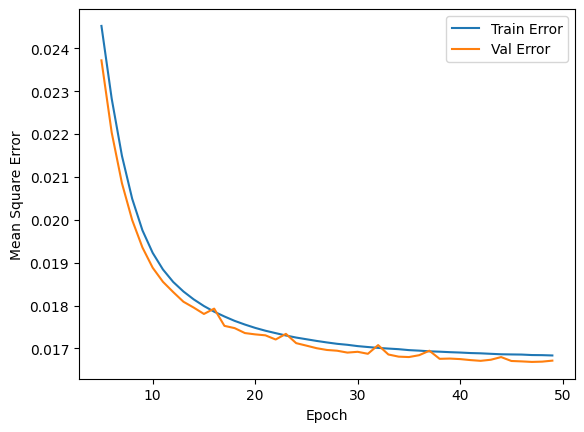

In [90]:
def plot_history(hist):

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist["mean_squared_error"],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label='Val Error')
    plt.legend()
    plt.show()


plot_history(hist.iloc[5:])

In [91]:
#make predictions
import numpy as np
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
from sklearn import metrics
print("MAE:",metrics.mean_absolute_error(y_test,testPredict))
print ("MSE:",metrics.mean_squared_error(y_test,testPredict))
print("RMSE train:",np.sqrt(metrics.mean_squared_error(y_train,trainPredict)))
print("RMSE test:",np.sqrt(metrics.mean_squared_error(y_test,testPredict)))

4467/4467 [==============================] - 7s 1ms/step
MAE: 0.08239769
MSE: 0.016715892
RMSE train: 0.12975432
RMSE test: 0.12928995
